In [ ]:
import os
import gc
import numpy as np
import pandas as pd
from utilis.constants import DATASET_PATHS
import matplotlib.pyplot as plt
import os
import json


# --- TensorFlow and Keras Imports ---
# Ensure you have tensorflow and scikit-learn installed:
# pip install tensorflow scikit-learn matplotlib
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress verbose TensorFlow logging
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.multiclass import unique_labels

 

In [2]:
#------------------------------------------------------------
# 1) Data loader (your function)
# ------------------------------------------------------------
from utilis.Data_loader import load_and_align_all_data
# Returns:
# (
#   all_combined_dfs,
#   all_individual_dfs_by_dataset,
#   label_encoder,
#   ALL_ENCODED_LABELS,
#   common_features,
#   broad_label_mapper,
#   broad_label_encoder
# )

In [3]:

# ------------------------------------------------------------
# 2) Utilities
# ------------------------------------------------------------
def build_sequences_matrix(X, y, seq_len=10, stride=None):
    """
    Build non-overlapping or strided sliding windows from flat arrays.
    label = last element label in the window.
    """
    if stride is None:
        stride = seq_len  # non-overlapping by default
    n = len(X)
    seqs = []
    labs = []
    for i in range(0, n - seq_len + 1, stride):
        seqs.append(X[i:i+seq_len])
        labs.append(y[i+seq_len-1])
    return np.asarray(seqs), np.asarray(labs)

def train_val_split(X, y, val_ratio=0.1, shuffle=True, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y))
    if shuffle:
        rng.shuffle(idx)
    n_val = int(len(y) * val_ratio)
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

def get_benign_id(broad_label_encoder):
    return broad_label_encoder.transform(["Benign"])[0]

def metrics_report(y_true, y_pred, class_names):
    labels = unique_labels(y_true, y_pred)  # actual labels in this fold
    report = classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=[class_names[i] for i in labels],
        zero_division=0,
        output_dict=True
    )
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred,
        average='weighted',
        zero_division=0
    )
    return acc, p, r, f1, report



In [4]:
# ------------------------------------------------------------
# 3) Models: LSTM-AE and Classifier
# ------------------------------------------------------------
def build_lstm_autoencoder(seq_len, n_features, latent=64, enc_units=(128,), dec_units=(128,)):
    """
    Simple LSTM Autoencoder:
      Encoder: LSTM stacks -> latent (Dense)
      Decoder: RepeatVector -> LSTM stacks -> TimeDistributed Dense
    """
    inp = layers.Input(shape=(seq_len, n_features))
    x = inp
    for i, u in enumerate(enc_units):
        x = layers.LSTM(u, return_sequences=True, name=f"enc_lstm_{i}")(x)
        print(f"Encoder LSTM {i} output shape: (batch, {seq_len}, {u})")

    x = layers.LSTM(enc_units[-1], return_sequences=False, name="enc_final")(x)
    print(f"Final Encoder output shape: (batch, {enc_units[-1]})")

    z = layers.Dense(latent, activation='linear', name="latent")(x)
    print(f"Latent vector shape: (batch, {latent})")

    # Decoder
    x = layers.RepeatVector(seq_len, name="repeat_vector")(z)
    print(f"After RepeatVector: (batch, {seq_len}, {latent})")

    for i, u in enumerate(dec_units):
        x = layers.LSTM(u, return_sequences=True, name=f"dec_lstm_{i}")(x)
        print(f"Decoder LSTM {i} output shape: (batch, {seq_len}, {u})")

    out = layers.TimeDistributed(layers.Dense(n_features, activation='linear') , name="recon")(x)
    print(f"Reconstruction shape: (batch, {seq_len}, {n_features})")


    ae = models.Model(inp, out, name="LSTM_AE")
    ae.summary()
    # Return encoder model up to latent
    encoder = models.Model(ae.input, ae.get_layer("latent").output, name="LSTM_Encoder")
    encoder.summary()

    ae.compile(optimizer=optimizers.Adam(1e-3), loss="mse")
    return ae, encoder


def build_classifier_from_encoder(encoder, seq_len, n_features, n_classes, head_units=(128,), freeze_encoder_epochs=3):
    # Clone encoder (keeps architecture, resets weights)
    encoder_clone = clone_model(encoder)
    encoder_clone.set_weights(encoder.get_weights())

    enc_inp = layers.Input(shape=(seq_len, n_features), name="cls_input")
    h = encoder_clone(enc_inp)

    for u in head_units:
        h = layers.Dense(u, activation="relu")(h)
        h = layers.Dropout(0.3)(h)
    out = layers.Dense(n_classes, activation="softmax", name="cls_out")(h)

    clf = models.Model(enc_inp, out, name="LSTM_AE_Classifier")

    # Freeze encoder initially
    for l in encoder_clone.layers:
        l.trainable = False

    clf.compile(optimizer=optimizers.Adam(1e-3),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
    return clf


In [5]:

def time_ordered_split(X, val_ratio=0.1):
    """
    Deterministic split preserving time order: first (1 - val_ratio) -> train,
    last val_ratio -> validation. No shuffling, avoids temporal leakage.
    """
    n = len(X)
    n_val = int(np.floor(val_ratio * n))
    n_train = n - n_val
    X_tr = X[:n_train]
    X_val = X[n_train:]
    return X_tr, X_val


In [6]:

def train_or_load_ae(
        X_train_seq, 
        seq_len, 
        n_features, 
        train_name , 
        ae_epochs=10, 
        batch_size=256, 
        verbose=1,
        latent=64,
        enc_units=(128,),
        dec_units=(128,),
        models_dir="lstmmodels",
        benign_only=False,
        compile_loaded=False,  # set True if you plan to continue training loaded models
        X_val_seq=None,
        shuffle_fit=False,
        monitor="val_loss",
        patience=3,
        build_lstm_autoencoder_fn=None  # inject your builder to avoid circular imports
):
    """
        Train or load an LSTM Autoencoder (AE) and its Encoder submodel.

        - If saved models exist (matching dataset tag), load them.
        - Else, train AE on X_train_seq (or a benign-only subset you pass in),
        validate with 10% split, save AE/Encoder and history.

        Returns:
            ae (tf.keras.Model)
            encoder (tf.keras.Model)
            history (dict)  # {} if not available on load
    """
    if build_lstm_autoencoder_fn is None:
        raise ValueError("Please pass build_lstm_autoencoder_fn=build_lstm_autoencoder")
    # --- Infer dataset tag ---
    if "2017" in train_name:
        dataset_tag = "2017"
    elif "2018" in train_name:
        dataset_tag = "2018"
    else:
        dataset_tag = train_name  # fallback if other dataset names used
    
    # include key config in filenames to avoid mismatches across runs
    cfg_tag = f"sl{seq_len}_nf{n_features}_lat{latent}_enc{'-'.join(map(str, enc_units))}_dec{'-'.join(map(str, dec_units))}"
    os.makedirs(models_dir, exist_ok=True)
    ae_path   = os.path.join(models_dir, f"ae_{dataset_tag}_{cfg_tag}.h5")
    enc_path  = os.path.join(models_dir, f"encoder_{dataset_tag}_{cfg_tag}.h5")
    hist_path = os.path.join(models_dir, f"history_{dataset_tag}_{cfg_tag}.json")

    # validate inputs
    if not isinstance(X_train_seq, np.ndarray) or X_train_seq.ndim != 3:
        raise ValueError(f"X_train_seq must be a 3D ndarray (batch, seq_len, n_features); got {type(X_train_seq)} with shape {getattr(X_train_seq, 'shape', None)}")
    if X_train_seq.shape[1] != seq_len or X_train_seq.shape[2] != n_features:
        raise ValueError(f"X_train_seq shape {X_train_seq.shape} does not match seq_len={seq_len}, n_features={n_features}.")



    # attempt to load both models
    if os.path.exists(ae_path):
        print(f"[INFO] Found AE at {ae_path}. Attempting to load AE/Encoder for {dataset_tag} (cfg: {cfg_tag}) ...")
        ae = load_model(ae_path, compile=compile_loaded)
        if os.path.exists(enc_path):
            encoder = load_model(enc_path, compile=False)
        else:
            # derive encoder from AE if missing
            print(f"[WARN] Encoder file missing. Rebuilding encoder from AE (layer 'latent').")
            encoder = tf.keras.Model(ae.input, ae.get_layer("latent").output, name="LSTM_Encoder")

        # optional compile if you will continue training a loaded model
        if compile_loaded:
            ae.compile(optimizer=optimizers.Adam(1e-3), loss="mse")

        history = {}
        if os.path.exists(hist_path):
            try:
                with open(hist_path, "r") as f:
                    history = json.load(f)
            except Exception as e:
                print(f"[WARN] Failed to load history: {e}. Continuing without history.")
                history = {}
        return ae, encoder, history


    

    # else, train fresh
    print(f"[INFO] Training AE for {dataset_tag} (cfg: {cfg_tag}) ...")

    ae, encoder = build_lstm_autoencoder_fn(seq_len=seq_len,
                                         n_features=n_features,
                                         latent=latent,
                                         enc_units=enc_units,
                                         dec_units=dec_units
                                         )
    es = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=3, restore_best_weights=True)
    ckpt = callbacks.ModelCheckpoint(
        ae_path, monitor=monitor, save_best_only=True, save_weights_only=False, verbose=1
    )

    if X_val_seq is not None:

        history_obj = ae.fit(
            X_train_seq, X_train_seq,
            validation_data=(X_val_seq, X_val_seq),
            epochs=ae_epochs,
            batch_size=batch_size,
            verbose=verbose,
            shuffle=shuffle_fit,
            callbacks=[es,ckpt]
        )
        
        # Convert to dict
        history = history_obj.history


    # Save models
     
    ae.save(ae_path)
    encoder.save(enc_path)

    try:
        with open(hist_path, "w") as f:
            json.dump(history, f)
    except Exception as e:
        print(f"[WARN] Failed to save history: {e}")

    return ae, encoder, history


--- Loading and Preprocessing CIC_IDS_2018 ---
[DEBUG] Now processing DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet in CIC_IDS_2018
DEBUG: Raw labels in DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter of CIC_IDS_2018 before harmonization: ['Benign', 'DDoS attacks-LOIC-HTTP']
Harmonized granular labels: {'DDoS', 'Benign'}
[DEBUG] Now processing Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet in CIC_IDS_2018
DEBUG: Raw labels in Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter of CIC_IDS_2018 before harmonization: ['Benign', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection']
Harmonized granular labels: {'Web Attack - SQL Injection', 'Web Attack - XSS', 'Web Attack - Brute Force', 'Benign'}
[DEBUG] Now processing Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet in CIC_IDS_2018
DEBUG: Raw labels in Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter of CIC_IDS_2018 before harmonization: ['Benign', 'Bot']
Harmonized granular labels: {'Benign', 'B

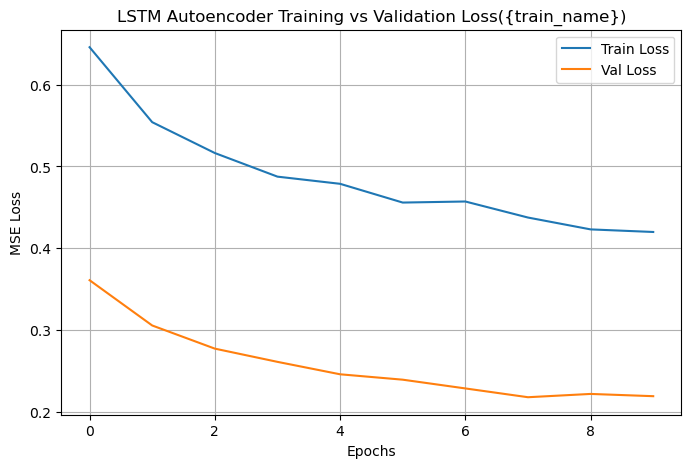

Benign median: 0.8191450834274292
Attack median: 6.592119216918945
Benign median: 0.8191451
Attack median: 6.592119


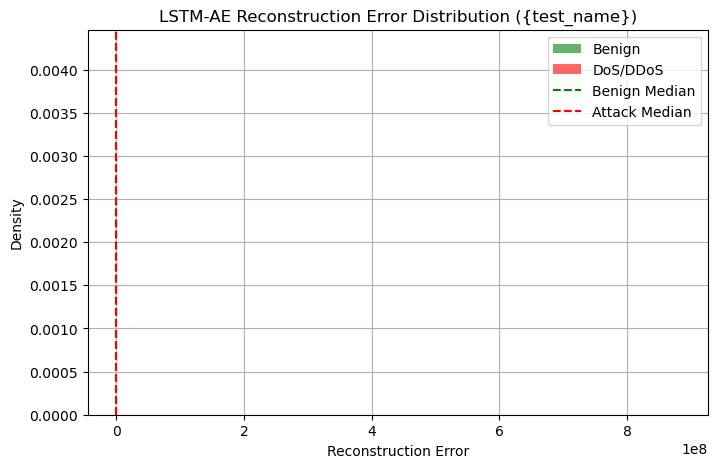

Model: "LSTM_AE_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cls_input (InputLayer)      [(None, 10, 70)]          0         
                                                                 
 LSTM_Encoder (Functional)   (None, 64)                241728    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 cls_out (Dense)             (None, 3)                 387       
                                                                 
Total params: 250,435
Trainable params: 8,707
Non-trainable params: 241,728
_________________________________________________________________
Class weights: {0: 0.3830101932634475,

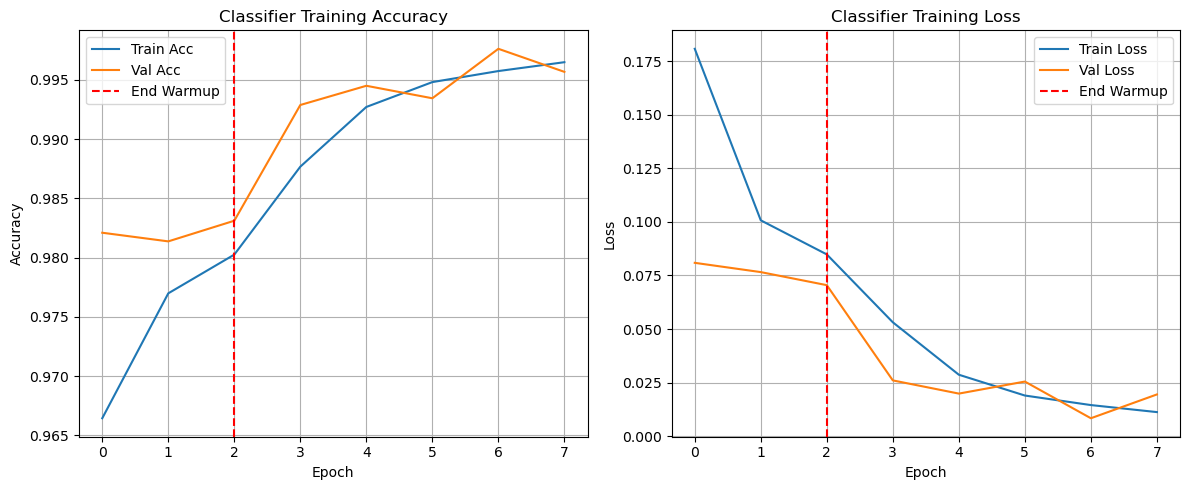


--- Evaluating on Full Test Set: CIC_IDS_2018 ---

[Test CIC_IDS_2018]  Acc=0.8560  P(w)= 0.7532  R(w)= 0.8560  F1(w)= 0.8007

################################################################################
### LSTM-AE: Train on CIC_IDS_2018  |  Test on CIC_IDS_2017
################################################################################
Class distribution (flat samples):
Train -> {0: 5759910, 3: 775955, 4: 196568}
Test -> {0: 2146901, 3: 128014, 4: 193745}
Train sequences: (673243, 10, 70), Test sequences: (246866, 10, 70)
Train sequences -> {'Benign': 576019, 'DDoS': 77597, 'DoS': 19627}
Train sequences  -> {0: 576019, 3: 77597, 4: 19627}
Test sequences  -> {'Benign': 214697, 'DDoS': 12801, 'DoS': 19368}
Test sequences  -> {0: 214697, 3: 12801, 4: 19368}
Benign id: 0
X_ae shape: (576019, 10, 70)
Found 576019 benign sequences for AE training.
AE pretraining benign sequences: 576019 / 673243
[INFO] Training AE for 2018 (cfg: sl10_nf70_lat64_enc128_dec128) ...
Encoder LSTM 0 o

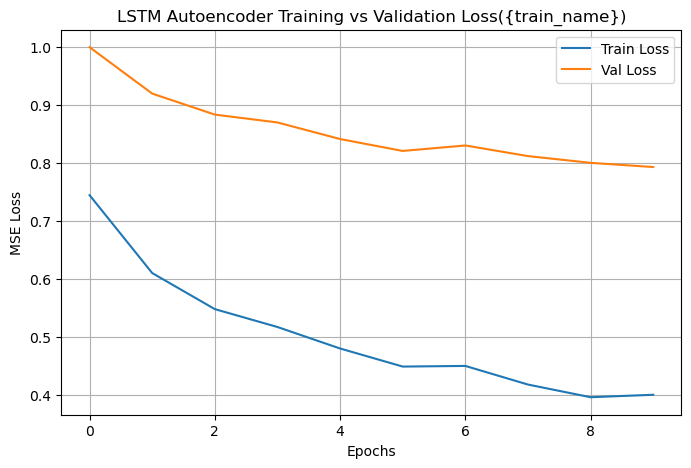

Benign median: 0.2433062493801117
Attack median: 11.748734474182129
Benign median: 0.24330625
Attack median: 11.748734


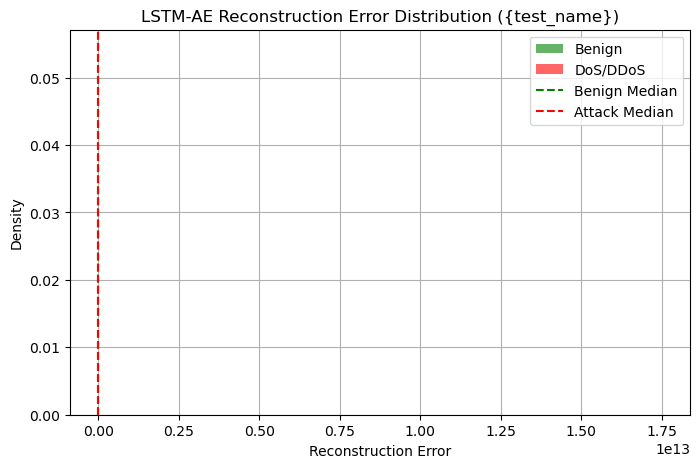

Model: "LSTM_AE_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cls_input (InputLayer)      [(None, 10, 70)]          0         
                                                                 
 LSTM_Encoder (Functional)   (None, 64)                241728    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 cls_out (Dense)             (None, 3)                 387       
                                                                 
Total params: 250,435
Trainable params: 8,707
Non-trainable params: 241,728
_________________________________________________________________
Class weights: {0: 0.38951523941032623

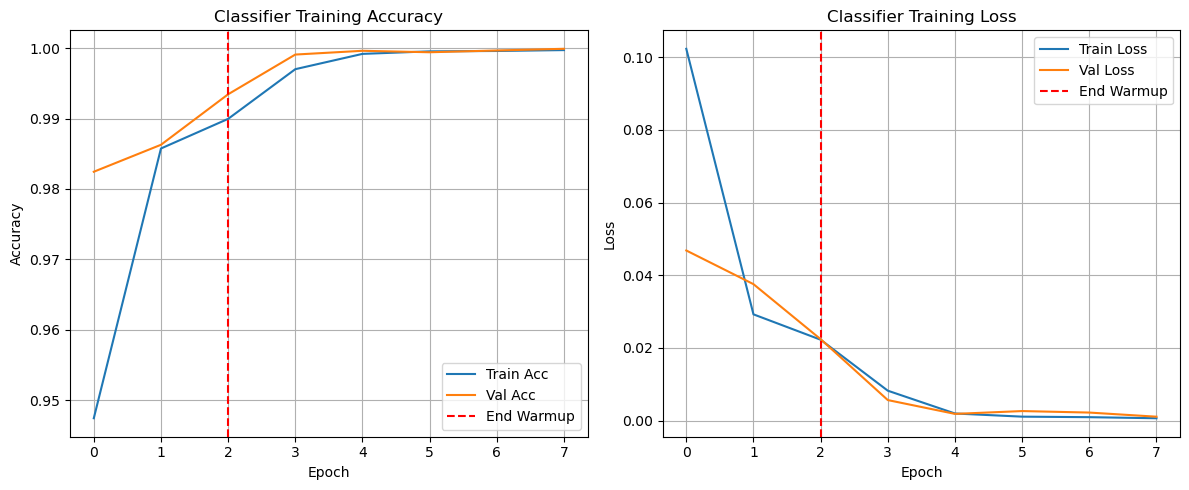


--- Evaluating on Full Test Set: CIC_IDS_2017 ---

[Test CIC_IDS_2017]  Acc=0.8753  P(w)= 0.8520  R(w)= 0.8753  F1(w)= 0.8383

RESULTS  Train=CIC_IDS_2017  Test=CIC_IDS_2018
Accuracy: 0.8560  F1(w): 0.8007  F1 Attack-only: 0.0980

--- Per-Day Metrics ---

Day: DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter
  Accuracy (weighted):  0.4137
  Precision (weighted): 0.1748
  Recall (weighted):    0.4137
  F1-score (weighted):  0.2457
  Classification Report:
    Benign: {'precision': 0.41976413929365275, 'recall': 0.9933518410286383, 'f1-score': 0.5901475694444445, 'support': 41064.0}
    DDoS: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 57548.0}
    DoS: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}
    accuracy: 0.41365148257818524
    macro avg: {'precision': 0.1399213797645509, 'recall': 0.3311172803428794, 'f1-score': 0.1967158564814815, 'support': 98612.0}
    weighted avg: {'precision': 0.1747981444038713, 'recall': 0.41365148257818524, 'f1-

In [ ]:

# ------------------------------------------------------------
# 4) Main cross-dataset routine
# ------------------------------------------------------------
def run_cross_lstm_ae(seq_len=10, stride=None, ae_epochs=10, clf_warmup_epochs=3, clf_ft_epochs=5,
                      batch_size=256, verbose=1, per_day=False):
    (
        all_combined_dfs,
        all_individual_dfs_by_dataset,
        _,
        _,
        common_features,
        broad_label_mapper,
        broad_label_encoder
    ) = load_and_align_all_data(DATASET_PATHS)

    tf.keras.utils.set_random_seed(42)
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

    scenarios = [
        ("CIC_IDS_2017", "CIC_IDS_2018"),
        ("CIC_IDS_2018", "CIC_IDS_2017"),
    ]

    results = {}

    for train_name, test_name in scenarios:
        print("\n" + "#"*80)
        print(f"### LSTM-AE: Train on {train_name}  |  Test on {test_name}")
        print("#"*80)

        # ---------- Select train/test flat frames ----------
        train_df = all_combined_dfs[train_name]
        test_df  = all_combined_dfs[test_name]

        # Features & labels (broad)
        X_train_flat  = train_df[common_features].fillna(0.0).to_numpy(dtype=np.float32)
        y_train_flat  = train_df["BroadLabel"].astype(int).to_numpy()
        X_test_flat  = test_df[common_features].fillna(0.0).to_numpy(dtype=np.float32)
        y_test_flat  = test_df["BroadLabel"].astype(int).to_numpy()

        # ---------- Allowed labels ----------
        
        benign_id = broad_label_encoder.transform(["Benign"])[0]
        dos_id    = broad_label_encoder.transform(["DoS"])[0]
        ddos_id   = broad_label_encoder.transform(["DDoS"])[0]
        allowed_labels = {benign_id,dos_id, ddos_id}

        # Filter training data  
        train_mask = np.isin(y_train_flat, list(allowed_labels))
        X_train_flat, y_train_flat = X_train_flat[train_mask], y_train_flat[train_mask]


        # Filter test data  
        test_mask = np.isin(y_test_flat, list(allowed_labels))
        X_test_flat, y_test_flat = X_test_flat[test_mask], y_test_flat[test_mask]


        

        # Print class distribution
        print("Class distribution (flat samples):")
        for name, arr in zip(["Train", "Test"], [y_train_flat, y_test_flat]):
            unique, counts = np.unique(arr, return_counts=True)
            pretty = {broad_label_encoder.inverse_transform([k])[0]: int(v) for k, v in zip(unique, counts)}
            print(f"{name} ->", dict(zip(unique, counts)))



        # Scale per-feature with train stats only
        scaler = StandardScaler()
        X_train_flat = scaler.fit_transform(X_train_flat).astype(np.float32)
        X_test_flat  = scaler.transform(X_test_flat).astype(np.float32)
        

        # ---------- Build sequences ----------
        X_train_seq, y_train_seq = build_sequences_matrix(X_train_flat, y_train_flat, seq_len=seq_len, stride=stride)
        X_test_seq,  y_test_seq  = build_sequences_matrix(X_test_flat,  y_test_flat,  seq_len=seq_len, stride=stride)
        
        print(f"Train sequences: {X_train_seq.shape}, Test sequences: {X_test_seq.shape}")

 
       

        # After sequence building
        unique, counts = np.unique(y_train_seq, return_counts=True)
        pretty = {broad_label_encoder.inverse_transform([k])[0]: int(v) for k, v in zip(unique, counts)}
        print("Train sequences ->", pretty)
        print("Train sequences  ->", dict(zip(unique, counts)))
         
        unique, counts = np.unique(y_test_seq, return_counts=True)
        pretty = {broad_label_encoder.inverse_transform([k])[0]: int(v) for k, v in zip(unique, counts)}
        print("Test sequences  ->", pretty)
        print("Test sequences  ->", dict(zip(unique, counts)))

        print("Benign id:", benign_id)
        

        # ---------- Stage 1: Pretrain LSTM-AE on Benign-only sequences ----------
         
        benign_mask_seq = (y_train_seq == benign_id)
        X_ae = X_train_seq[benign_mask_seq]
        print("X_ae shape:", X_ae.shape)
        print(f"Found {len(X_ae)} benign sequences for AE training.")
        print(f"AE pretraining benign sequences: {X_ae.shape[0]} / {X_train_seq.shape[0]}")

        # Train/val split for AE
        X_ae_tr, X_ae_val = time_ordered_split(X_ae, val_ratio=0.1)
        
        seq_len_eff = X_train_seq.shape[1]
        n_features = X_train_seq.shape[2]
         

        # Train or Load AE 
        ae, encoder, history = train_or_load_ae(
            X_train_seq=X_ae_tr,
            seq_len=seq_len_eff,
            n_features=n_features,
            train_name=train_name,
            ae_epochs=ae_epochs,
            batch_size=batch_size,
            verbose=verbose,
            latent=64,
            enc_units=(128,),
            dec_units=(128,),
            models_dir="lstmmodels",
            benign_only=True,
            compile_loaded=False,
            X_val_seq=X_ae_val,      # explicit validation set (no double validation)
            shuffle_fit=False,       # avoid temporal leakage in batching
            monitor="val_loss",
            patience=3,
            build_lstm_autoencoder_fn=build_lstm_autoencoder  # pass your builder
)
        

        
        # ---- Plot AE training vs validation loss ----
        import matplotlib.pyplot as plt

        if history is not None:
            plt.figure(figsize=(8,5))
            plt.plot(history.get("loss", []), label="Train Loss")
            plt.plot(history.get("val_loss", []), label="Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("MSE Loss")
            plt.title("LSTM Autoencoder Training vs Validation Loss({train_name})")
            plt.legend()
            plt.grid(True)
            plt.show()
         

        # --- Compute reconstruction error ---
        def compute_recon_error(ae, X):
            recon = ae.predict(X, verbose=0)
            errors = np.mean((X - recon) ** 2, axis=(1,2))  # MSE per sequence
            return errors

        # Reconstruction errors
        benign_mask_test = (y_test_seq == benign_id)
        X_test_benign = X_test_seq[benign_mask_test]
        X_test_attack = X_test_seq[~benign_mask_test]

        if len(X_test_benign) > 0:
            benign_errors = compute_recon_error(ae, X_test_benign)
            print("Benign median:", float(np.median(benign_errors)))
        else:
            benign_errors = np.array([])
            print("Benign median: N/A (no benign sequences)")

        if len(X_test_attack) > 0:
            attack_errors = compute_recon_error(ae, X_test_attack)
            print("Attack median:", float(np.median(attack_errors)))
        else:
            attack_errors = np.array([])
            print("Attack median: N/A (no attack sequences)")


        print("Benign median:", np.median(benign_errors))
        print("Attack median:", np.median(attack_errors))

        if len(benign_errors) and len(attack_errors):
            # --- Plot histograms ---
            plt.figure(figsize=(8,5))
            plt.hist(benign_errors, bins=50, alpha=0.6, label="Benign", color="green", density=True)
            plt.hist(attack_errors, bins=50, alpha=0.6, label="DoS/DDoS", color="red", density=True)
            plt.axvline(np.median(benign_errors), color="green", linestyle="--", label="Benign Median")
            plt.axvline(np.median(attack_errors), color="red", linestyle="--", label="Attack Median")
            plt.xlabel("Reconstruction Error")
            plt.ylabel("Density")
            plt.title("LSTM-AE Reconstruction Error Distribution ({test_name})")
            plt.legend()
            plt.grid(True)
            plt.show()


        # ---------- Stage 2: Classifier from pretrained encoder ----------
        # 1) Create stable mapping for labels present in training sequences
        unique_labels = np.unique(y_train_seq)  # original label ids present (e.g., [benign_id, dos_id, ddos_id])
        label_map = {old: new for new, old in enumerate(unique_labels)}            # original -> local idx
        inv_label_map = {v: k for k, v in label_map.items()}    

        # 2) Map training labels and then split (to keep mapping consistent)
        y_train_seq_mapped = np.array([label_map[y] for y in y_train_seq])
        Xc_tr, yc_tr, Xc_val, yc_val = train_val_split(X_train_seq, y_train_seq_mapped, val_ratio=0.1, shuffle=True)

        # 3) Build classifier head with exact number of classes present
        n_classes_local = len(unique_labels)
        clf = build_classifier_from_encoder(
            encoder, seq_len_eff, n_features, n_classes_local,
            head_units=(128,), freeze_encoder_epochs=clf_warmup_epochs
        )
        clf.summary()

 
 
 

        # Class weights to mitigate imbalance
        classes_present = np.unique(yc_tr) # now [0,1,2]
        cls_w = compute_class_weight('balanced', classes=classes_present, y=yc_tr)
        class_weight = {int(c): float(w) for c, w in zip(classes_present, cls_w)}

        print("Class weights:", class_weight)
        print("Label map (internal -> original id):", inv_label_map)


        # ---- Stage 2: Warmup with frozen encoder ----
        es2 = callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

        
        history_warmup = clf.fit(
                Xc_tr, yc_tr,
                validation_data=(Xc_val, yc_val),
                epochs=clf_warmup_epochs,
                batch_size=batch_size,
                class_weight=class_weight,
                verbose=verbose,
                callbacks=[es2]
            )

        # Unfreeze encoder & fine-tune
        for l in clf.layers:
            l.trainable = True
        clf.compile(optimizer=optimizers.Adam(3e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        es3 = callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
        
        history_ft= clf.fit(
                Xc_tr, yc_tr,
                validation_data=(Xc_val, yc_val),
                epochs=clf_ft_epochs,
                batch_size=batch_size,
                class_weight=class_weight,
                verbose=verbose,
                callbacks=[es3])
        # ---- Combine both histories ----
        def combine_histories(h1, h2):
            hist = {}
            for k in h1.history.keys():
                hist[k] = h1.history[k] + h2.history[k]
            return hist

        history_full = combine_histories(history_warmup, history_ft)

        # ---- Plot curves ----
        plt.figure(figsize=(12,5))

        # Accuracy
        plt.subplot(1,2,1)
        plt.plot(history_full.get("accuracy", []), label="Train Acc")
        plt.plot(history_full.get("val_accuracy", []), label="Val Acc")
        plt.axvline(len(history_warmup.history.get("accuracy", [])) - 1, color="r", linestyle="--", label="End Warmup")
        plt.title("Classifier Training Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        # Loss
        plt.subplot(1,2,2)
        plt.plot(history_full.get("loss", []), label="Train Loss")
        plt.plot(history_full.get("val_loss", []), label="Val Loss")
        plt.axvline(len(history_warmup.history.get("loss", [])) - 1, color="r", linestyle="--", label="End Warmup")
        plt.title("Classifier Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.show()

        # ---------- Evaluate on the test dataset ----------
        print(f"\n--- Evaluating on Full Test Set: {test_name} ---")
  
        y_pred_probs = clf.predict(X_test_seq, batch_size=batch_size, verbose=0)
        y_pred_local = np.argmax(y_pred_probs, axis=1)
        # Map local indices back to original label ids
        y_pred_orig = np.array([inv_label_map[i] for i in y_pred_local])

        acc, p, r, f1, report = metrics_report(y_test_seq, y_pred_orig, class_names=broad_label_encoder.classes_)
        print(f"\n[Test {test_name}]  Acc={acc:.4f}  P(w)= {p:.4f}  R(w)= {r:.4f}  F1(w)= {f1:.4f}")

        # Optional “attack-only” F1 (exclude Benign)
        attack_class_names = [c for c in broad_label_encoder.classes_ if c != "Benign"]
        attack_ids = broad_label_encoder.transform(attack_class_names)
        mask_attack = np.isin(y_test_seq, attack_ids)
        f1_attack_only = f1_score(
            y_test_seq[mask_attack], y_pred_orig[mask_attack],
            average="weighted", zero_division=0
        ) if mask_attack.sum() > 0 else np.nan

        results[(train_name, test_name)] = {
            "overall": {
                "accuracy": acc,
                "precision_weighted": p,
                "recall_weighted": r,
                "f1_weighted": f1,
                "f1_weighted_attack_only": f1_attack_only,
                "report": report
            }
        }

        # ---------- Optional: per-day evaluation ----------
        if per_day:
            per_day_metrics = {}
            indiv = all_individual_dfs_by_dataset[test_name]
            for day_name, df_day in indiv.items():
                if df_day.empty: 
                    continue
                Xd = df_day[common_features].fillna(0.0).to_numpy(dtype=np.float32)
                yd = df_day["BroadLabel"].astype(int).to_numpy()
                Xd = scaler.transform(Xd).astype(np.float32)
                Xd_seq, yd_seq = build_sequences_matrix(Xd, yd, seq_len=seq_len, stride=stride)
                if len(yd_seq) == 0:
                    continue
                # Predict local indices then map back to original ids
                ypd_local = np.argmax(clf.predict(Xd_seq, batch_size=batch_size, verbose=0), axis=1)
                ypd_orig = np.array([inv_label_map[i] for i in ypd_local])

                 
                accd, pd_, rd_, f1d, repd = metrics_report(yd_seq, ypd_orig, class_names=broad_label_encoder.classes_)
                per_day_metrics[day_name] = {
                    "accuracy": accd,
                    "precision_weighted": pd_,
                    "recall_weighted": rd_,
                    "f1_weighted": f1d,
                    "report": repd
                }
            results[(train_name, test_name)]["per_day"] = per_day_metrics

        # Cleanup between scenarios
        del ae, encoder, clf, X_train_seq, X_test_seq, X_train_flat, X_test_flat
        del Xc_tr, Xc_val, yc_tr, yc_val, X_ae, X_ae_tr
        gc.collect()
        tf.keras.backend.clear_session()

    return results

# ------------------------------------------------------------
# 5) Run
# ------------------------------------------------------------
if __name__ == "__main__":
    out = run_cross_lstm_ae(
        seq_len=10,          # try 10, 20, 30
        stride=10,           # non-overlapping; use e.g. 5 for 50% overlap
        ae_epochs=10,        # bump to 20–50 if you have time/GPU
        clf_warmup_epochs=3,
        clf_ft_epochs=5,
        batch_size=256,
        verbose=1,
        per_day=True         # set False if you only want overall metrics
    )

    # Pretty print overall metrics
    for (tr, te), res in out.items():
        ov = res["overall"]
        print("\n" + "="*80)
        print(f"RESULTS  Train={tr}  Test={te}")
        print(f"Accuracy: {ov['accuracy']:.4f}  F1(w): {ov['f1_weighted']:.4f}  F1 Attack-only: {ov['f1_weighted_attack_only']:.4f}")

        if "per_day" in res:
            print("\n--- Per-Day Metrics ---")
            for day, metrics in res["per_day"].items():
                print(f"\nDay: {day}")
                print(f"  Accuracy (weighted):  {metrics['accuracy']:.4f}")
                print(f"  Precision (weighted): {metrics['precision_weighted']:.4f}")
                print(f"  Recall (weighted):    {metrics['recall_weighted']:.4f}")
                print(f"  F1-score (weighted):  {metrics['f1_weighted']:.4f}")
                
                # If you also stored classification_report dict:
                if "report" in metrics:
                    print("  Classification Report:")
                    for label, stats in metrics["report"].items():
                        print(f"    {label}: {stats}")
